In [11]:
import numpy as np
import pandas as pd
import yaml
import os
from ultralytics import YOLO
import SimpleITK as sitk
from pathlib import Path
import glob

In [8]:
def generate_yaml(fold):
    os.makedirs('data_yaml', exist_ok=True)
    info = {
        'path': 'dataset',
        'train': [f'images/subset{i}' for i in range(10) if i != fold],
        'val': f'images/subset{fold}',
        'names': {
            0: 'none',
            1: 'nodule'
        }
    }
    with open(f'data_yaml/fold{fold}.yaml', 'w') as y:
        yaml.dump(info, y, default_flow_style=False)

for i in range(10):
    generate_yaml(i)

In [23]:
def annotate(uid, voxel_coords, diameter):
    file = glob.glob(f'dataset/images/subset*/{uid}*.npz')[0]
    
    data = np.load(file)
    old_origin = data['origin']
    old_size = data['resampled_size']
    old_spacing = data['original_spacing']
    new_spacing = data['resampled_spacing']

    vox_resampled = (voxel_coords - old_origin) / new_spacing
    scale_x = 1024 / old_size[0]
    scale_y = 1024 / old_size[1]
    vox_scaled = np.array([vox_resampled[0] * scale_x, vox_resampled[1] * scale_y, vox_resampled[2]])
    radius_x = ((diameter / 2) / new_spacing[0]) * scale_x
    radius_y = ((diameter / 2) / new_spacing[1]) * scale_y

    x1 = vox_scaled[0] - radius_x
    y1 = vox_scaled[1] - radius_y
    x2 = vox_scaled[0] + radius_x
    y2 = vox_scaled[1] + radius_y
    cx = (x1 + x2) / 2 / 1024
    cy = (y1 + y2) / 2 / 1024
    w = (x2 - x1) / 1024
    h = (y2 - y1) / 1024
    sliceno = int(round(vox_scaled[2]))
    
    annofile = file.replace('images', 'labels').replace('.npz', f'.{sliceno:03d}.txt')
    with open(annofile, 'w') as f:
        f.write(f'1 {cx} {cy} {w} {h}\n')



In [25]:
# Read annotations CSV and run annotate() for each row
df = pd.read_csv('data/annotations.csv')

for idx, row in df.iterrows():
    # Support both named columns and positional layout
    if 'uid' in df.columns:
        uid = str(row['uid'])
        x = float(row['x'])
        y = float(row['y'])
        z = float(row['z'])
        diameter = float(row['diameter'])
    else:
        uid = str(row.iloc[0])
        x = float(row.iloc[1])
        y = float(row.iloc[2])
        z = float(row.iloc[3])
        diameter = float(row.iloc[4])

    try:
        annotate(uid, (x, y, z), diameter)
    except Exception as e:
        print(f"Row {idx} (uid={uid}): annotate failed -> {e}")

Row 111 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531): annotate failed -> list index out of range
Row 116 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.130036599816889919308975074972): annotate failed -> list index out of range
Row 117 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843): annotate failed -> list index out of range
Row 122 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957): annotate failed -> list index out of range
Row 125 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366): annotate failed -> list index out of range
Row 126 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366): annotate failed -> list index out of range
Row 129 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441): annotate failed -> list index out of range
Row 130 (uid=1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441): annotate failed -> list index out of range
Row 131 (uid=1.3

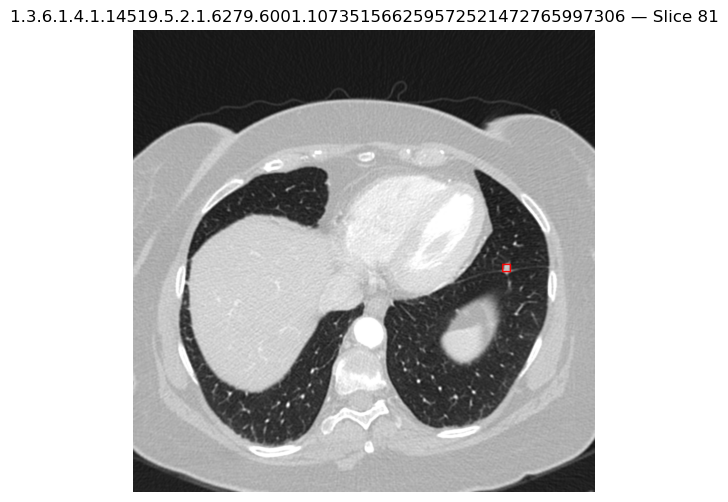

In [27]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def visualize_annotation(uid, sliceno):
    # Load the slice PNG
    img_path = f"dataset/images/subset*/{uid}.{sliceno:03d}.png"
    # glob-style lookup
    import glob
    matches = glob.glob(img_path)
    if len(matches) == 0:
        raise FileNotFoundError(f"No slice image found for pattern {img_path}")
    img_path = matches[0]

    img = Image.open(img_path).convert("L")
    W, H = img.size

    # Load YOLO label
    label_path = img_path.replace("images", "labels").replace(".png", ".txt")
    with open(label_path, "r") as f:
        line = f.readline().strip().split()
    _, cx, cy, w, h = map(float, line)

    # Convert YOLO normalized coords → pixel coords
    cx_px = cx * W
    cy_px = cy * H
    w_px = w * W
    h_px = h * H

    x1 = cx_px - w_px/2
    y1 = cy_px - h_px/2
    x2 = cx_px + w_px/2
    y2 = cy_px + h_px/2

    # Draw bounding box
    img_draw = img.convert("RGB")
    draw = ImageDraw.Draw(img_draw)
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

    # Show figure
    plt.figure(figsize=(6, 6))
    plt.imshow(img_draw, cmap="gray")
    plt.title(f"{uid} — Slice {sliceno}")
    plt.axis("off")
    plt.show()


# Example usage:
visualize_annotation("1.3.6.1.4.1.14519.5.2.1.6279.6001.107351566259572521472765997306", 81)


In [28]:
fold_metrics = []

for i in range(10):
    model = YOLO('yolov8l.pt')
    results = model.train(
        data=f'data_yaml/fold{i}.yaml',
        epochs=5,
        optimizer='SGD',
        lr0=0.001,
        momentum=0.937,
        weight_decay=0.0005
    )
    fold_metrics.append(results)


New https://pypi.org/project/ultralytics/8.3.233 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.232 🚀 Python-3.10.18 torch-2.8.0 CUDA:0 (NVIDIA GeForce RTX 5080, 16303MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data_yaml/fold0.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=No